In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Processing incidents data

Aggregate the incidents data into grids with side lengths of 500m and calculate the centroid of each grid. Calculate the response time of each event. The definition of response time here is reaction seconds plus driving seconds according to the requirements.

In [3]:
incidents = pd.read_csv('Data/WMFS_datasets/wmfs_incidents.csv')
# Only pay attention to incidents of type 'FIRE' and 'FALSE_ALARM'
incidents = incidents[incidents['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]
incidents = incidents.reset_index(drop=True)

In [4]:
### Aggregate the data into grids
# Define the grid size
grid_size = 500

# Calculate the bound
xmin = incidents['EASTINGS'].min() // grid_size * grid_size # // means quotient rounding
xmax = incidents['EASTINGS'].max() // grid_size * grid_size + grid_size # rounding down so another grid needs to be added
ymin = incidents['NORTHINGS'].min() // grid_size * grid_size
ymax = incidents['NORTHINGS'].max() // grid_size * grid_size + grid_size
# Caculate the grid index
incidents['grid_x'] = ((incidents['EASTINGS'] - xmin) // grid_size).astype(int)
incidents['grid_y'] = ((incidents['NORTHINGS'] - ymin) // grid_size).astype(int)

# Add a grid_id to each incident and fire station
incidents['grid_id'] = incidents['grid_x'].astype(str) + "_" + incidents['grid_y'].astype(str)

In [5]:
### Caculate the centroid of each grid
incidents['centroid_x'] = xmin + (incidents['grid_x'] + 0.5) * grid_size
incidents['centroid_y'] = ymin + (incidents['grid_y'] + 0.5) * grid_size

# Extract the centroid coordinates into a new dataframe to facilitate merging later
grid_centroids = incidents[['grid_id', 'centroid_x', 'centroid_y']].drop_duplicates().reset_index(drop=True)
grid_centroids

,grid_id,centroid_x,centroid_y
0,12_29,392250.0,286750.0
1,39_11,405750.0,277750.0
2,48_33,410250.0,288750.0
3,21_54,396750.0,299250.0
4,49_36,410750.0,290250.0
...,...,...,...
3729,79_22,425750.0,283250.0
3730,68_8,420250.0,276250.0
3731,2_32,387250.0,288250.0
3732,69_9,420750.0,276750.0


In [6]:
# Define 'total response time'
incidents['total_response_time'] = incidents['reaction_seconds'] + incidents['driving_seconds']
incidents

,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,driving_seconds,grid_x,grid_y,grid_id,centroid_x,centroid_y,total_response_time
0,2009/1/1 0:00,False alarm raised with good intent,False Alarms,FALSE_ALARM,2,0,392062.1020,286844.9690,86,160,250,12,29,12_29,392250.0,286750.0,410
1,2009/1/1 0:10,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,405643.1494,277939.9802,85,65,239,39,11,39_11,405750.0,277750.0,304
2,2009/1/1 0:11,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410260.2444,288819.1894,62,106,115,48,33,48_33,410250.0,288750.0,221
3,2009/1/1 0:53,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,396779.2503,299030.1061,72,109,96,21,54,21_54,396750.0,299250.0,205
4,2009/1/1 0:52,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410667.9614,290492.4786,68,109,204,49,36,49_36,410750.0,290250.0,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292692,2023/12/31 22:59,False Alarms (Equipment),Low Risk,FALSE_ALARM,2,0,398666.6867,283225.4570,88,82,281,25,22,25_22,398750.0,283250.0,363
292693,2023/12/31 23:11,False alarm raised with good intent,False Alarms,FALSE_ALARM,1,1,433136.8678,277909.0307,134,94,98,94,11,94_11,433250.0,277750.0,192
292694,2023/12/31 23:32,Accidental secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,401134.3304,277356.6820,136,152,227,30,10,30_10,401250.0,277250.0,379
292695,2023/12/31 23:49,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,406221.0587,290654.1816,253,66,297,40,37,40_37,406250.0,290750.0,363


### 2. Exploratory Data Anaylsis

In [7]:
# Get time information
time_feature = incidents[['grid_id', 'total_response_time']]

incidents['call_time'] = pd.to_datetime(incidents['call_time'])

def get_season(time):
    month = time.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'
    # if month in [1, 2, 12]:
    #     return True
    # else:
    #     return False
    
def is_rush_hour(time):
    hour = time.hour
    return (7 <= hour < 10) or (16 <= hour < 20)

def is_weekend(time):
    day_of_week = time.weekday()
    return day_of_week >= 5

time_feature['season'] = incidents['call_time'].apply(get_season)
time_feature['is_rush_hour'] = incidents['call_time'].apply(is_rush_hour)
time_feature['is_weekend'] = incidents['call_time'].apply(is_weekend)

time_feature

/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_44159/3286940167.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_feature['season'] = incidents['call_time'].apply(get_season)
/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_44159/3286940167.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_feature['is_rush_hour'] = incidents['call_time'].apply(is_rush_hour)
/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_44159/3286940167.py:31: SettingWithCopyWarning: 
A valu

,grid_id,total_response_time,season,is_rush_hour,is_weekend
0,12_29,410,Winter,False,False
1,39_11,304,Winter,False,False
2,48_33,221,Winter,False,False
3,21_54,205,Winter,False,False
4,49_36,313,Winter,False,False
...,...,...,...,...,...
292692,25_22,363,Winter,False,True
292693,94_11,192,Winter,False,True
292694,30_10,379,Winter,False,True
292695,40_37,363,Winter,False,True


#### Season

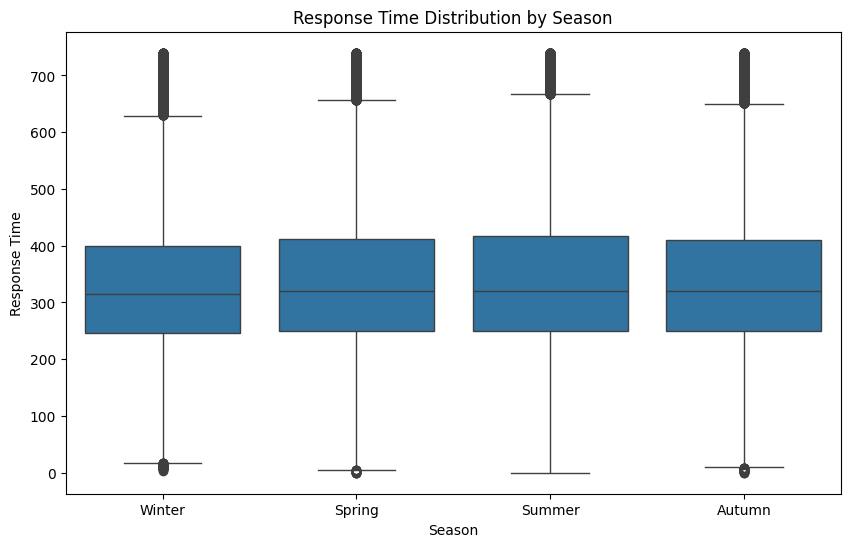

In [9]:
threshold = time_feature['total_response_time'].quantile(0.95)
time_feature = time_feature[time_feature['total_response_time'] < threshold]

# The difference of response time between seasons
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='total_response_time', data=time_feature)
plt.xlabel('Season')
plt.ylabel('Response Time')
plt.title('Response Time Distribution by Season')
plt.show()

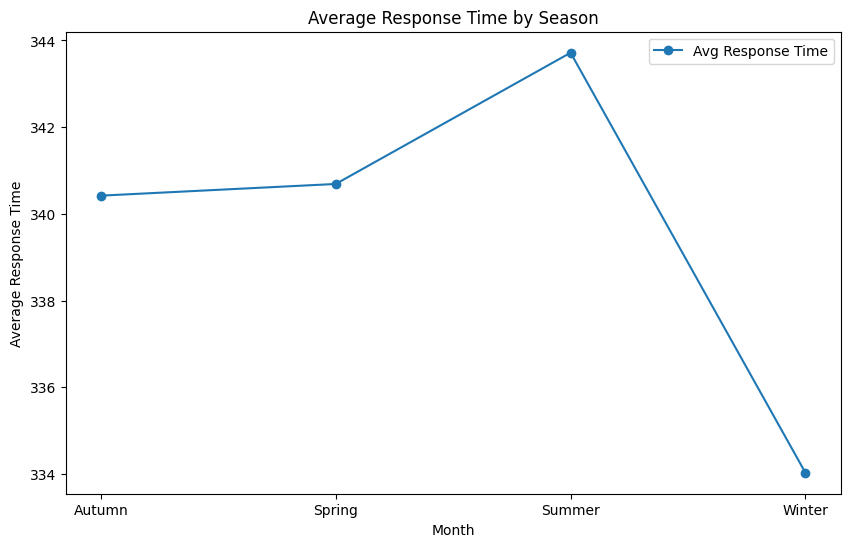

In [10]:
# Plot the average response time of each season
seasonly_response_time = time_feature.groupby('season')['total_response_time'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(seasonly_response_time['season'], seasonly_response_time['total_response_time'], marker='o', label='Avg Response Time')
plt.xlabel('Month')
plt.ylabel('Average Response Time')
plt.title('Average Response Time by Season')
plt.legend(loc='upper right')

plt.show()


In [11]:
### t test
from scipy.stats import ttest_ind

winter_time = time_feature[time_feature['season'] == 'Winter']['total_response_time']
non_winter_time = time_feature[time_feature['season'] != 'Winter']['total_response_time']

t_stat, p_value = ttest_ind(winter_time, non_winter_time)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -12.380175448645682, P-value: 3.4184444561838284e-35


#### Commuting Time

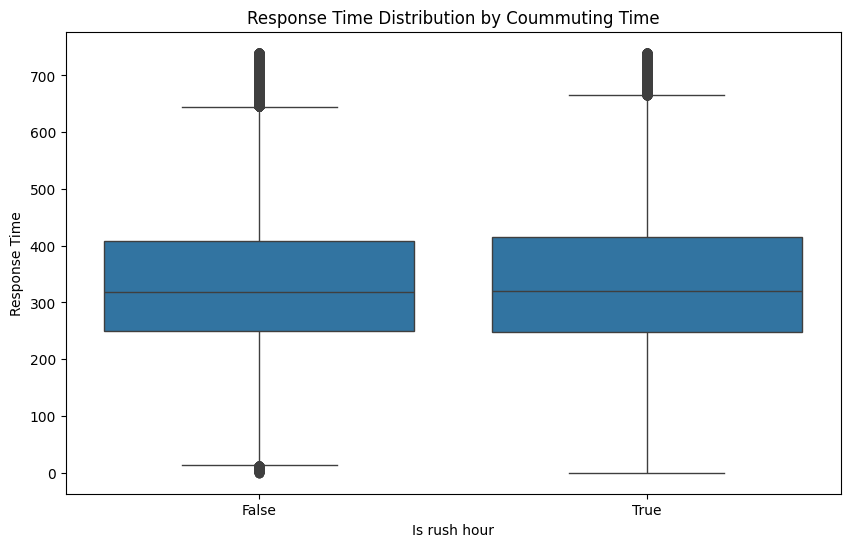

In [12]:
# The difference of response time between commuting time
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_rush_hour', y='total_response_time', data=time_feature)
plt.xlabel('Is rush hour')
plt.ylabel('Response Time')
plt.title('Response Time Distribution by Coummuting Time')
plt.show()

In [13]:
### t test

rush_hour = time_feature[time_feature['is_rush_hour'] == True]['total_response_time']
non_rush_hour = time_feature[time_feature['is_rush_hour'] == False]['total_response_time']

t_stat, p_value = ttest_ind(rush_hour, non_rush_hour)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 6.487580792601416, P-value: 8.737114112298016e-11


#### Weekdays and Weekends

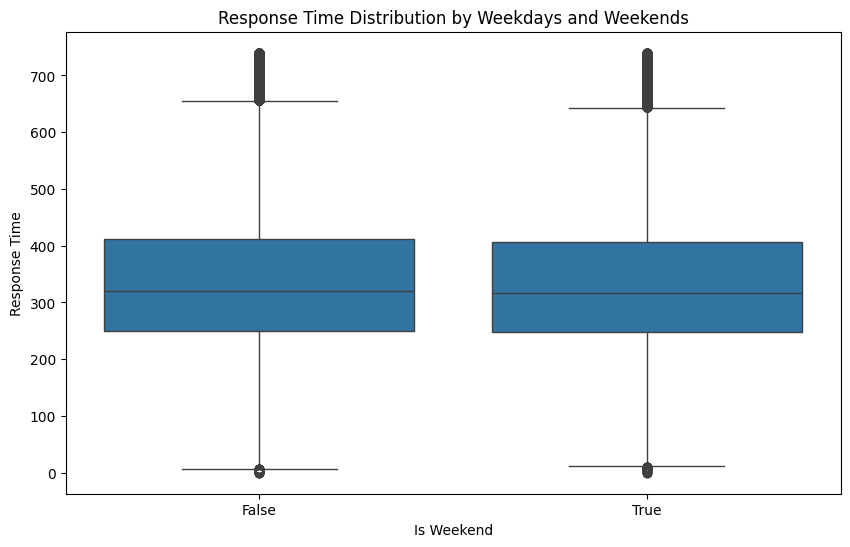

In [14]:
# The difference of response time between weekdays and weekends
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_weekend', y='total_response_time', data=time_feature)
plt.xlabel('Is Weekend')
plt.ylabel('Response Time')
plt.title('Response Time Distribution by Weekdays and Weekends')
plt.show()

In [15]:
### t test

weekends = time_feature[time_feature['is_weekend'] == True]['total_response_time']
weekdays = time_feature[time_feature['is_weekend'] == False]['total_response_time']

t_stat, p_value = ttest_ind(weekends, weekdays)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -5.272884019067779, P-value: 1.343964327408071e-07
